# Getting Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
from urllib.request import urlopen
from bs4 import BeautifulSoup

In [3]:
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
html = urlopen(url)

In [4]:
soup = BeautifulSoup(html, 'lxml')

In [9]:
text = soup.get_text()

# Data Exploration

In [13]:
text[0:100]

'\n\n\nList of postal codes of Canada: M - Wikipedia\ndocument.documentElement.className=document.documen'

Finding the start and end of the table

In [24]:
position1 = text.index("start with M0.")
position1 += len("start with M0.")
position1

4413

In [22]:
position2 = text.index("Most populated FSAs")
position2

13766

In [25]:
textFiltered = text[position1:position2]

In [27]:
textFiltered[0:100]

'\n\n\n\nPostcode\nBorough\nNeighbourhood\n\n\nM1A\nNot assigned\nNot assigned\n\n\nM2A\nNot assigned\nNot assigned\n\n'

# Extracting the necessary data

In [29]:
textSplit = textFiltered.split('\n')
textSplit[0:10]

['', '', '', '', 'Postcode', 'Borough', 'Neighbourhood', '', '', 'M1A']

In [31]:
for i in range(len(textSplit)-1,-1,-1):
    if textSplit[i] == '':
        del(textSplit[i])
textSplit[0:10]

['Postcode',
 'Borough',
 'Neighbourhood',
 'M1A',
 'Not assigned',
 'Not assigned',
 'M2A',
 'Not assigned',
 'Not assigned',
 'M3A']

Assumption: the postcodes are arranged alphabetically

In [49]:
from collections import OrderedDict     # to keep the columns in the same order

c1 = []
c2 = []
c3 = []
for i in range(3,len(textSplit),3):
    if textSplit[i+1] != 'Not assigned':
        if len(c1) == 0:
            c1.append(textSplit[i])
            c2.append(textSplit[i+1])
            if textSplit[i+2] == 'Not assigned': 
                # If a cell has a borough but a Not assigned neighborhood, 
                # then the neighborhood will be the same as the borough
                c3.append(textSplit[i+1])
            else:
                c3.append(textSplit[i+2])
        elif c1[-1] == textSplit[i]:
            # More than one neighborhood can exist in one postal code area.
            # These two rows will be combined into one row with
            # the neighborhoods separated with a comma
            c3[-1] = c3[-1] + "," + textSplit[i+2]
        else:
            c1.append(textSplit[i])
            c2.append(textSplit[i+1])
            if textSplit[i+2] == 'Not assigned': 
                # If a cell has a borough but a Not assigned neighborhood, 
                # then the neighborhood will be the same as the borough
                c3.append(textSplit[i+1])
            else:
                c3.append(textSplit[i+2])

myData = pd.DataFrame(OrderedDict({'Postcode':c1,
                                   'Borough':c2,
                                   'Neighbourhood':c3}
                                 ))
    
    

In [50]:
myData.head(11)

,Postcode,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Harbourfront,Regent Park"
3,M6A,North York,"Lawrence Heights,Lawrence Manor"
4,M7A,Queen's Park,Queen's Park
5,M9A,Etobicoke,Islington Avenue
6,M1B,Scarborough,"Rouge,Malvern"
7,M3B,North York,Don Mills North
8,M4B,East York,"Woodbine Gardens,Parkview Hill"
9,M5B,Downtown Toronto,"Ryerson,Garden District"


In [51]:
myData.shape

(103, 3)

# Getting coordinates:

In [53]:
myCoordinatesFile = "Geospatial_Coordinates.csv"
coordinatesTable = pd.read_csv(myCoordinatesFile)

In [54]:
coordinatesTable.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [55]:
myData2 = pd.merge(myData,
                   coordinatesTable,
                   left_on = "Postcode",
                   right_on="Postal Code",
                  how='left')

In [56]:
myData2.head()

,Postcode,Borough,Neighbourhood,Postal Code,Latitude,Longitude
0,M3A,North York,Parkwoods,M3A,43.753259,-79.329656
1,M4A,North York,Victoria Village,M4A,43.725882,-79.315572
2,M5A,Downtown Toronto,"Harbourfront,Regent Park",M5A,43.654260,-79.360636
3,M6A,North York,"Lawrence Heights,Lawrence Manor",M6A,43.718518,-79.464763
4,M7A,Queen's Park,Queen's Park,M7A,43.662301,-79.389494


# Clustering

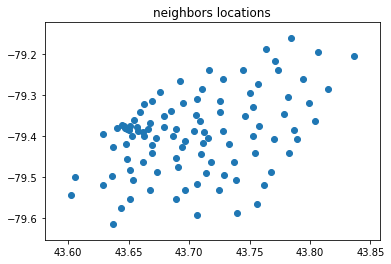

In [59]:
plt.scatter(x=myData2['Latitude'],y=myData2['Longitude'])
plt.title("neighbors locations")
plt.show()

In [61]:
k = 3
clustersX = np.random.uniform(min(myData2['Latitude']),max(myData2['Latitude']),size = k)
clustersY = np.random.uniform(min(myData2['Longitude']),max(myData2['Longitude']),size = k)

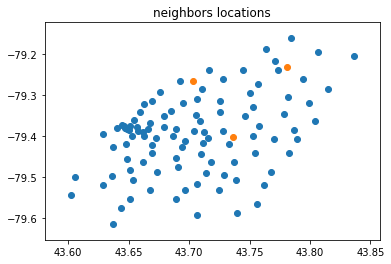

In [63]:
plt.scatter(x=myData2['Latitude'],y=myData2['Longitude'])
plt.scatter(x = clustersX, y = clustersY)
plt.title("neighbors locations")
plt.show()

In [67]:
#cluster assignment
Xs = [[] for i in range(k)]
Ys = [[] for i in range(k)]

    
for i in range(len(myData2)):
    x = myData2.loc[i]["Latitude"]
    y = myData2.loc[i]["Longitude"]
    
    dist = np.sqrt( (x - clustersX) ** 2  + (y- clustersY) **2)
    minDistCluster = np.argmin(dist)
    
    Xs[minDistCluster].append(x)
    Ys[minDistCluster].append(y)

    

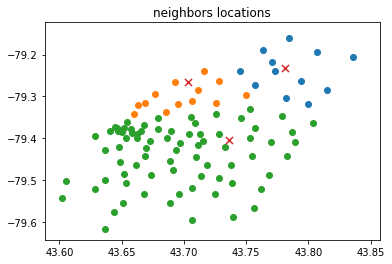

In [81]:
for i in range(k):
    plt.scatter(x=Xs[i],y=Ys[i])
plt.scatter(x = clustersX, y = clustersY, marker = 'x', s = 50)
plt.title("neighbors locations")
plt.show()

In [88]:
for i in range(k):
    clustersX[i] = np.mean(Xs[i])
    clustersY[i] = np.mean(Ys[i])


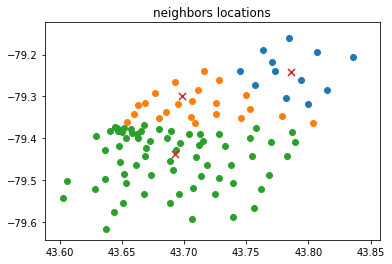

In [89]:
Xs = [[] for i in range(k)]
Ys = [[] for i in range(k)]

    
for i in range(len(myData2)):
    x = myData2.loc[i]["Latitude"]
    y = myData2.loc[i]["Longitude"]
    
    dist = np.sqrt( (x - clustersX) ** 2  + (y- clustersY) **2)
    minDistCluster = np.argmin(dist)
    
    Xs[minDistCluster].append(x)
    Ys[minDistCluster].append(y)

for i in range(k):
    plt.scatter(x=Xs[i],y=Ys[i])
plt.scatter(x = clustersX, y = clustersY, marker = 'x', s = 50)
plt.title("neighbors locations")
plt.show()

In [93]:
for steps in range(100):
    # centroids updates
    for i in range(k):
        clustersX[i] = np.mean(Xs[i])
        clustersY[i] = np.mean(Ys[i])

    #points assignemnt:
    Xs = [[] for i in range(k)]
    Ys = [[] for i in range(k)]


    for i in range(len(myData2)):
        x = myData2.loc[i]["Latitude"]
        y = myData2.loc[i]["Longitude"]

        dist = np.sqrt( (x - clustersX) ** 2  + (y- clustersY) **2)
        minDistCluster = np.argmin(dist)

        Xs[minDistCluster].append(x)
        Ys[minDistCluster].append(y)

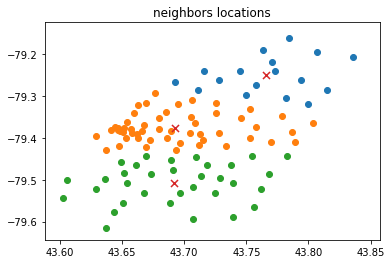

In [94]:
for i in range(k):
    plt.scatter(x=Xs[i],y=Ys[i])
plt.scatter(x = clustersX, y = clustersY, marker = 'x', s = 50)
plt.title("neighbors locations")
plt.show()